In [1]:
##
##
## ResNet analog from Keras resnet50
##
## maximum on LB => ????
##
## 2017-05-20
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [6]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, Conv2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [7]:
keras.__version__

'2.0.4'

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
def formImExt (nf, resize=(32,32), printOK=False) :
    nx = None
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            #ni = cv.normalize
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
            if (ni.shape[2]==3) :
                nx = cv.resize(ni,resize)
            if (ni.shape[2]==4) :
                #r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,0],ni[:,:,3]
                r,g,b,n = cv.resize(ni[:,:,2],resize),cv.resize(ni[:,:,1],resize),cv.resize(ni[:,:,0],resize),cv.resize(ni[:,:,3],resize)
                dv,dw   = np.divide((r-n),(r+n+0.01)), np.divide((g-n),(g+n+0.01))
                nx      = np.array([r,g,b,n,dv,dw]).T; 
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

In [33]:
trX, trY, i, size = [],[], 0, len(nameList)
print(datetime.datetime.now(),len(nameList),size)
for nn in nameList[0:size] :
    #nf = os.path.join(trDirTIF,nn+".tif");
    nf = os.path.join(trDirJPG,nn+".jpg");
    nx = formImExt(nf,resize=(64,64))
    if (nx is not None) :
        #rr=np.save(os.path.join(trWork,nn+".npy"),nx);
        #trX.append(nn+".npy")
        trX.append(nx)
        trY.append(True)
    else : 
        trY.append(False)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
    #print(nn.shape)

print(datetime.datetime.now())
trX = np.array(trX);
trY = labelList[trY];
print(len(nameList),trX.shape,trY.shape)
#trXY=pd.DataFrame(trY); trXY['name']=trX; trXY.head()
#trXY.to_pickle(os.path.join(trWork,"listFiles.pkl"))

2017-05-18 16:09:51.030338 40479 40479
2017-05-18 16:12:30.271675 	 5000 	 train_4999
2017-05-18 16:14:32.662155 	 10000 	 train_9999
2017-05-18 16:16:21.170086 	 15000 	 train_14999
2017-05-18 16:17:57.485082 	 20000 	 train_19999
2017-05-18 16:19:17.573212 	 25000 	 train_24999
2017-05-18 16:20:26.649529 	 30000 	 train_29999
2017-05-18 16:21:34.931734 	 35000 	 train_34999
2017-05-18 16:22:38.544159 	 40000 	 train_39999
2017-05-18 16:22:44.600525
40479 (40479, 64, 64, 3) (40479, 17)


In [34]:
#np.save('../Data-Keras/train-model-2D-64x64x6-v2-XX.npy',trX)
#np.save('../Data-Keras/train-model-2D-64x64x6-v2-YY.npy',trY)
np.save('../Data-Keras/train-model-2D-64x64x3-v2-XX.npy',trX)
np.save('../Data-Keras/train-model-2D-64x64x3-v2-YY.npy',trY)

In [160]:
#del(trOX); del(trOY);

In [173]:
#trX = np.load('../Data-Keras/train-model-2D-64x64x6-v2-XX.npy')
#trY = np.load('../Data-Keras/train-model-2D-64x64x6-v2-YY.npy')
trX = np.load('../Data-Keras/train-model-2D-64x64x3-v2-XX.npy')
trY = np.load('../Data-Keras/train-model-2D-64x64x3-v2-YY.npy')
print(trX.shape,trY.shape)

(40479, 64, 64, 3) (40479, 17)


In [174]:
trX=trX/255.0
#trX = cv.normalize(trX, trX, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
#trX=trX/65535.0
#trX[0,:,:]
#trX[:,:,:,5].max(),trX.min(),trX.shape

In [34]:
def fbeta_loss(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    yy_pred = K.round(y_pred+(0.5-OK1))
    #yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [18]:
#
# for ResNet 18,34 filter=(filter1,filter2)
#

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2= filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = ZeroPadding2D((1,1))(input_tensor)
    
    x = Conv2D(filters1, kernel_size, strides=strides,
               name=conv_name_base + '2a')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    
    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    

    shortcut = Conv2D(filters2, (1,1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [459]:
def ResNetXX(input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    '''
    # Arguments
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    '''
    
    """
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)
    """
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    '''
    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    '''

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    
    x = conv_block(x, 3, [64, 64], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64], stage=2, block='b')
    #x = identity_block(x, 3, [64, 64], stage=2, block='c')
    
    x = conv_block(x, 3, [128, 128], stage=3, block='a', strides=(1, 1))
    x = identity_block(x, 3, [128, 128], stage=3, block='b')
    #x = identity_block(x, 3, [128, 128], stage=3, block='c')

    
    x = conv_block(x, 3, [256, 256], stage=4, block='a', strides=(1, 1))
    x = identity_block(x, 3, [256, 256], stage=4, block='b')
    
    
    #x = conv_block(x, 3, [512, 512], stage=5, block='a', strides=(1, 1))
    #x = identity_block(x, 3, [512, 512], stage=5, block='b')
    
    #x = conv_block(x, 3, [1024, 1024], stage=5, block='a', strides=(1, 1))
    #x = identity_block(x, 3, [1024, 1024], stage=5, block='b')
    
    
    x = AveragePooling2D((7, 7), name='avg_pool')(x)
    #x = AveragePooling2D((2, 2), name='avg_pool')(x)

    x = Flatten()(x)
    #x = Dense(256,activation='relu')(x)
    #x = Dropout(0.5)(x)
    #x = Dense(classes, activation='softmax', name='fc1000')(x)
    x = Dense(classes, activation='sigmoid', name='fc1000')(x)
        
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnetXX')

    return model

In [471]:
from keras import layers
from keras.layers import AveragePooling2D
from keras.models import Model
from keras.utils.data_utils import get_file

#WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
#WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = ResNetXX(input_shape=(64,64,3),classes=17)

In [461]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_71 (InputLayer)            (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_268 (ZeroPadding2 (None, 70, 70, 3)     0           input_71[0][0]                   
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 32, 32, 64)    9472        zero_padding2d_268[0][0]         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 32, 32, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

In [424]:
def _fbeta_loss(y_true, y_pred):
    beta2 = 4.
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.))))
    precision, recall = tp/K.clip(tp_fp,K.epsilon(),tp_fp), tp/K.clip(tp+fn,K.epsilon(),tp+fn) 
    fbeta = 1.-(1.+beta2)*(precision*recall)/K.clip(beta2*precision+recall,K.epsilon())
    return(1.-(1.+beta2)*(precision*recall)/K.clip(beta2*precision+recall,K.epsilon(),beta2*precision+recall))

In [462]:
def buildModel (iSize,rSize) :
    model = ResNetXX(input_shape=iSize,classes=rSize)
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer="nadam", #sgd, #"adam", #'rmsprop',
                  metrics=[fbeta_pred]) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

In [514]:
trY_small = trY

In [510]:
wr = [labels.index(i) for i in weather_labels]; trY_small = trY[:,wr]; 
wr,trY_small.shape

([3, 10, 0, 9], (40479, 4))

In [511]:
iSize, rSize, result = (trX.shape[1],trX.shape[2],trX.shape[3]), trY_small.shape[1], []

model1 = buildModel(iSize,rSize)

tr1=np.sum([K.count_params(p) for p in set(model1.trainable_weights)])
tr2=np.sum([K.count_params(p) for p in set(model1.non_trainable_weights)])

print(iSize,rSize,tr1+tr2)

(64, 64, 3) 4 2109892


In [512]:
if False :
    
    #model.load_weights('../Data-Keras/weights_of_best_model_sigmoid_nadam_4.hdf5') ## best weight
    model1 = buildModel(iSize,17) #rSize)
    model2 = buildModel(iSize,4) #rSize)
    model2.load_weights('../Data-Keras/weights_of_best_model_sigmoid_nadam_4.hdf5') ## best weight
    
    i=0
    for ii in model2.layers :
        #print(ii.name);
        if (i>0) and (i<(len(model2.layers)-2)) :
            print(i,ii.name);
            model1.layers[i].set_weights(ii.get_weights())
        i = i+1
    print(model1.layers[len(model1.layers)-1].name,model1.layers[len(model1.layers)-2].name)
    #len(model1.layers)
    #model1.save_weights('../Data-Keras/weights_initial_resnet_sigmoid_17.h5') 
    

zero_padding2d_296
conv1
bn_conv1
activation_1274
max_pooling2d_73
zero_padding2d_297
res2a_branch2a
bn2a_branch2a
activation_1275
res2a_branch2b
bn2a_branch2b
res2a_branch1
activation_1276
bn2a_branch1
add_400
activation_1277
res2b_branch2a
bn2b_branch2a
activation_1278
res2b_branch2b
bn2b_branch2b
activation_1279
add_401
activation_1280
zero_padding2d_298
res3a_branch2a
bn3a_branch2a
activation_1281
res3a_branch2b
bn3a_branch2b
res3a_branch1
activation_1282
bn3a_branch1
add_402
activation_1283
res3b_branch2a
bn3b_branch2a
activation_1284
res3b_branch2b
bn3b_branch2b
activation_1285
add_403
activation_1286
zero_padding2d_299
res4a_branch2a
bn4a_branch2a
activation_1287
res4a_branch2b
bn4a_branch2b
res4a_branch1
activation_1288
bn4a_branch1
add_404
activation_1289
res4b_branch2a
bn4b_branch2a
activation_1290
res4b_branch2b
bn4b_branch2b
activation_1291
add_405
activation_1292
avg_pool
fc1000 flatten_76


IOError: Unable to create file (Unable to truncate a file which is already open)

In [515]:
trY_small.shape
#model1.load_weights('../Data-Keras/weights_initial_resnet_sigmoid_17.h5')


(40479, 17)

In [516]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

epochs  = 100
verbose = 2
batch_size = 64
initial = 0

if (tr1+tr2)>14500000 : 
    print(datetime.datetime.now(),pp,tr1+tr2,'(badly)')
else :        
        
    filepath="../Data-Keras/weights.{epoch:02d}-{fbeta_pred:.2f}-{val_fbeta_pred:.2f}.hdf5"
    filepath="../Data-Keras/weights_of_best_model_softmax.hdf5"
    filepath="../Data-Keras/weights_of_best_model_sigmoid_nadam_4.hdf5"
    filepath="../Data-Keras/weights_of_best_model_sigmoid_nadam_17.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_fbeta_pred', verbose=1, save_best_only=True, mode='max')
    #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    #checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
    
    print(datetime.datetime.now(),'nodes=',tr1+tr2)
    hist_softmax  = model1.fit(trX,trY_small,
                        initial_epoch=initial,
                        epochs=epochs+initial, batch_size=batch_size, validation_split=0.2, 
                        #callbacks=[early_stopping,reduce_lr,checkpoint],
                        callbacks=[checkpoint,early_stopping],
                        verbose=verbose)
    
    trP = model1.predict(trX, batch_size=batch_size)
    
    fbeta2score=fbeta_score(trY_small, np.array(trP) > 0.2, beta=2, average='samples')
    fbeta2pred =K.get_value(fbeta_pred(trY_small.astype(np.float64),trP.astype(np.float64)))
    #print(datetime.datetime.now(),pp,hist1.history['fbeta_pred'][-1],hist1.history['val_fbeta_pred'][-1],'fbeta2s=',fbeta2score,fbeta2pred)
    print(datetime.datetime.now(),'fbeta2s=',fbeta2score,fbeta2pred)


2017-05-22 11:04:24.335693 nodes= 2109892
Train on 32383 samples, validate on 8096 samples
Epoch 1/100
Epoch 00000: val_fbeta_pred improved from -inf to 0.84590, saving model to ../Data-Keras/weights_of_best_model_sigmoid_nadam_17.hdf5
114s - loss: 0.0745 - fbeta_pred: 0.8410 - val_loss: 0.0739 - val_fbeta_pred: 0.8459
Epoch 2/100
Epoch 00001: val_fbeta_pred did not improve
100s - loss: 0.0704 - fbeta_pred: 0.8532 - val_loss: 0.0728 - val_fbeta_pred: 0.8456
Epoch 3/100
Epoch 00002: val_fbeta_pred did not improve
100s - loss: 0.0705 - fbeta_pred: 0.8530 - val_loss: 0.0745 - val_fbeta_pred: 0.8333
Epoch 4/100
Epoch 00003: val_fbeta_pred did not improve
100s - loss: 0.0702 - fbeta_pred: 0.8545 - val_loss: 0.0846 - val_fbeta_pred: 0.7901
Epoch 5/100
Epoch 00004: val_fbeta_pred did not improve
100s - loss: 0.0702 - fbeta_pred: 0.8547 - val_loss: 0.0757 - val_fbeta_pred: 0.8273
Epoch 6/100
Epoch 00005: val_fbeta_pred did not improve
100s - loss: 0.0703 - fbeta_pred: 0.8541 - val_loss: 0.0746

In [470]:
#model1.load_weights('../Data-Keras/weights.07-0.86-0.83.hdf5') ##
#model1.load_weights('../Data-Keras/weights_of_best_model_softmax.hdf5') ## best weights
#model1.load_weights('../Data-Keras/weights_of_best_model_sigmoid_nadam_4.hdf5') ## best weights
model1.load_weights('../Data-Keras/weights_of_best_model_sigmoid_nadam_17.hdf5') ## best weights
print(model1.evaluate(trX,trY_small,verbose=2,batch_size=batch_size))
trP = model1.predict(trX, batch_size=batch_size)
print(trY_small.shape)
print(trP.shape)
print('fbeta_score=',fbeta_score(trY_small, np.array(trP) > 0.2, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY_small.astype(np.float64),trP.astype(np.float64),OK1=0.2)))
#plt.hist(trP.flatten()); plt.show()

[0.04438319368251431, 0.91760892008141293]
(40479, 4)
(40479, 4)
fbeta_score= 0.89923993511
fbeta_pred = 0.9176300733


In [468]:
#model1.load_weights('../Data-Keras/weights_of_best_model_softmax.hdf5') ## best weights

In [247]:
print(model1.evaluate(trX,trY,verbose=2,batch_size=batch_size))
trP = model1.predict(trX, batch_size=batch_size)
print(trY.shape)
print(trP.shape)
print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64),OK1=0.2)))
#plt.hist(trP.flatten()); plt.show()

[0.33942034220962897, 0.85421489789736316]
(40479, 17)
(40479, 17)
fbeta_score= 0.668507353332
fbeta_pred = 0.775708254265


In [97]:
trPP = trP[0:2]
trYY = trY[0:2]
print('fbeta_score1=',fbeta_score(trYY, np.array(trPP) > 0.2, beta=2, average='samples'))
print('fbeta_score2=',fbeta_score(trYY, np.round(trPP+(0.5-0.2)).astype(np.uint8), beta=2, average='samples'))
print('fbeta_pred  =',K.get_value(fbeta_pred(trYY.astype(np.float64),trPP.astype(np.float64),printOK=True,OK1=0.2)))
trYY,np.round(trPP+(0.5-0.2)).astype(np.uint8),trPP.max()

fbeta_score1= 0.424836601307
fbeta_score2= 0.424836601307
ten true  [[ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
ten roun  [[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
 pre= 0.333333277778  recall= 0.9999995  tp= 2.0  fn= 0.0  tp+fp= 6.0
fbeta_pred  = 0.714285153061


(array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8),
 0.66138786)

In [98]:
5*0.33*1.0/(4*0.33+1)

0.7112068965517241

In [134]:
model = model1

In [135]:
save_model(model,'../Data-Keras/train-model-2D-2-v2-all.h5')
model.save_weights('../Data-Keras/train-model-2D-2-v2-weights-resnet.h5')  # save weights after training

In [136]:
rr, rrx = [], []; trP = model.predict(trX, batch_size=128)
for i in range(trP.shape[1]) :
    xx = [];
    trYY = trY[:,i].astype(np.float64)
    trPY = trP[:,i]
    for ii in range(100) :
        trPP = (trPY>0.01*ii).astype(np.float64)
        #x = fbeta_score(trY[:,0], np.array(trP[:,0] > 0.1*ii), beta=2, average='samples')
        x = K.get_value(fbeta_pred(trYY,trPP))
        xx.append(x)
    rrr = np.array(xx).argmax();
    rr.append(rrr)
    rrx.append(xx[rrr])
    print(datetime.datetime.now(),i,'-->',rrr,xx[rrr],xx[(rrr-1):(rrr+2)])
    #print(xx);
    #plt.plot(np.array(xx)); plt.show()
trM = np.array(rr)/100.0;

2017-05-21 04:33:29.868062 0 --> 12 0.701061456789 [0.69027836079096705, 0.70106145678882503, 0.70097333966554642]
2017-05-21 04:34:46.820765 1 --> 18 0.970360673025 [0.97028825116911765, 0.97036067302471052, 0.96925310898663897]
2017-05-21 04:36:09.395277 2 --> 14 0.787397912978 [0.78418708954033389, 0.78739791297818562, 0.78739256385420475]
2017-05-21 04:37:37.568402 3 --> 14 0.960480052616 [0.96047590680428074, 0.96048005261587177, 0.95978748962279092]
2017-05-21 04:39:11.964028 4 --> 20 0.660986706165 [0.65612739214963112, 0.66098670616463051, 0.66098097939318778]
2017-05-21 04:40:52.131403 5 --> 7 0.598958064523 [0.58823505932796361, 0.59895806452306344, 0.58685894275107442]
2017-05-21 04:42:37.846685 6 --> 6 0.713505952554 [0.70583410290540627, 0.71350595255370186, 0.70250832497474558]
2017-05-21 04:44:29.077766 7 --> 9 0.585068476993 [0.58490668135597612, 0.58506847699323372, 0.56409315329175058]


KeyboardInterrupt: 

In [145]:
for iii in range(10,30) :
    print(iii,'fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64),OK1=iii/100.0)))

10 fbeta_pred = 0.852262799278
11 fbeta_pred = 0.85860954729
12 fbeta_pred = 0.863598218022
13 fbeta_pred = 0.867415899366
14 fbeta_pred = 0.870350360537
15 fbeta_pred = 0.872115891222
16 fbeta_pred = 0.873628123981
17 fbeta_pred = 0.873875118136
18 fbeta_pred = 0.872978397105
19 fbeta_pred = 0.87111173067
20 fbeta_pred = 0.868017511052
21 fbeta_pred = 0.863709761266
22 fbeta_pred = 0.857957813086
23 fbeta_pred = 0.849860113255
24 fbeta_pred = 0.841126318708
25 fbeta_pred = 0.831194119535
26 fbeta_pred = 0.820387882662
27 fbeta_pred = 0.809047783749
28 fbeta_pred = 0.797786636371
29 fbeta_pred = 0.787032754149


In [26]:
model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights-resnet.h5') 

In [146]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [147]:
#nameAsk = os.listdir(teDirI); print(len(nameAsk))
nameAsk = os.listdir(teDirJPG); print(len(nameAsk))
trOX, trOY, i, ii, size = [], [], 0, 0, len(nameAsk)
print(datetime.datetime.now(),len(nameAsk),size)
for nn in nameAsk[0:size] :
    #nf = os.path.join(teDirTIF,nn);
    nf = os.path.join(teDirJPG,nn);
    nx = formImExt(nf,resize=(64,64))
    if (nx is not None) :
        trOX.append(nx)
        trOY.append(nn)
    i += 1
    if (i%10000==0) and (i>1) :
        if (ii==0) :
            trOX = np.array(trOX); trOX = trOX / 255.0
            trP = model.predict(trOX, batch_size=512); 
        else :
            trOX = np.array(trOX);  trOX = trOX / 255.0
            trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
        trOX,ii = [],ii+1;
    if (i%5000==0) : print(datetime.datetime.now(),"\t",ii,'\t',i,"\t",nn,'\t',(trP.shape if ii>0 else ""))

if (len(trOX)>0) :
    if (ii==0) :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = model.predict(trOX, batch_size=512); 
    else :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
    trOX,ii = [],ii+1;
    
print(datetime.datetime.now())

#assert (size!=len(trOY)), "Wrong files {} != {}".format(size,len(trOY))

61191
2017-05-21 04:51:36.884908 61191 61191
2017-05-21 04:51:44.366410 	 0 	 5000 	 test_14523.jpg 	 
2017-05-21 04:51:57.129539 	 1 	 10000 	 test_19029.jpg 	 (10000, 17)
2017-05-21 04:52:04.310439 	 1 	 15000 	 test_23524.jpg 	 (10000, 17)
2017-05-21 04:52:16.162226 	 2 	 20000 	 test_28015.jpg 	 (20000, 17)
2017-05-21 04:52:22.850290 	 2 	 25000 	 test_32520.jpg 	 (20000, 17)
2017-05-21 04:52:34.361601 	 3 	 30000 	 test_37026.jpg 	 (30000, 17)
2017-05-21 04:52:41.050391 	 3 	 35000 	 test_4908.jpg 	 (30000, 17)
2017-05-21 04:52:52.574351 	 4 	 40000 	 test_9402.jpg 	 (40000, 17)
2017-05-21 04:52:59.475271 	 4 	 45000 	 file_13913.jpg 	 (40000, 17)
2017-05-21 04:53:10.554489 	 5 	 50000 	 file_18419.jpg 	 (50000, 17)
2017-05-21 04:53:31.752280 	 5 	 55000 	 file_4564.jpg 	 (50000, 17)
2017-05-21 04:53:47.705018 	 6 	 60000 	 file_892.jpg 	 (60000, 17)
2017-05-21 04:53:50.410902


In [156]:
#trOX = np.array(trOX);
trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(len(nameAsk),trP.shape,trOY.shape)

61191 (61191, 17) (61191,)


In [ ]:
# Saving & Loading

In [26]:
np.save('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy',trOX)
np.save('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy',trOY)

In [27]:
trOX = np.load('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy')
trOY = np.load('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy')
print(trOX.shape,trOY.shape)

(61191, 32, 32, 6) (61191,)


In [37]:
rrx
rrd=dict()
for i in range(len(rrx)) :
    rrd[i]=rrx[i]
rrd

{0: 0.75841929007857778,
 1: 0.98263848366246676,
 2: 0.84722629763157453,
 3: 0.97604678247993626,
 4: 0.78729476795032916,
 5: 0.78956810256787635,
 6: 0.83083164404299403,
 7: 0.73801616416924898,
 8: 0.6761901702314258,
 9: 0.86068787363532673,
 10: 0.96403428373772715,
 11: 0.90053737661152566,
 12: 0.6528441526860862,
 13: 0.86359942524081812,
 14: 0.37037005520335736,
 15: 0.68382329252278806,
 16: 0.58917169677281178}

In [258]:
#Forming result

In [148]:
#trP = model.predict(trOX, batch_size=512); 
trP.shape, trP[-1]

((61191, 17), array([  1.51678212e-02,   2.47970134e-01,   4.04648930e-02,
          1.49414241e-01,   4.00180258e-02,   3.28476608e-01,
          1.54203057e-01,   1.21361157e-03,   2.60228753e-05,
          3.93420953e-04,   2.10836772e-02,   1.34721558e-04,
          1.17336481e-03,   4.00833051e-05,   8.84044348e-05,
          1.29057618e-04,   2.91726406e-06], dtype=float32))

In [161]:
trM=np.array([0.0]*len(labels)); print(trM.shape)
wr = [labels.index(i) for i in weather_labels];
trM[:]=0.5 ### 0.17 ################ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

(17,)
[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.5, 0.5, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 2.0, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


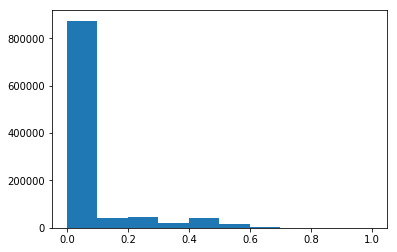

In [167]:
len(res), len(trOY), trOY[0:3]
plt.hist(trP.flatten()); plt.show()

In [163]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trPP = [weather_labels[trP[i,wr].argmax()]] + [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])];
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear'] 
 ['file_20521', 'clear primary'] 
 [ 2.   0.5  0.5  2.   0.5  0.5  0.5  0.5  0.5  2.   2.   0.5  0.5  0.5  0.5
  0.5  0.5] [  5.69364019e-02   1.46626368e-01   5.61825596e-02   3.07105750e-01
   2.11413950e-01   5.84495859e-03   8.64350051e-03   1.33131153e-03
   3.46140841e-05   1.83510408e-01   1.28348945e-02   5.12083773e-07
   9.52941086e-03   6.62975083e-07   2.47126104e-06   7.83156437e-08
   2.20744641e-06]


In [164]:
print(labels)
#print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [165]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-21-05-08-35


In [52]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [53]:
def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    '''
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)
    '''
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    '''
    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)
    '''
    
    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc1000')(x)
        
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models',
                                    md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='avg_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1000')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model